In [1]:
import pykep as pk
import pygmo as pg
from datetime import datetime as dt
import numpy as np
from random import random as rn

# Plotting imports
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

**INTRODUCTION TO TRAJECTORY MODELING**

Trajectory modeling is simulating the dynamics of an in-space body going from point A to point B. Because of gravity and orbital mechanics, things cannot take a direct path as you'd think like on Earth's surface. Everything has non-zero position and velocity, everything is in an orbit relative to something.

Two specific 'problems' are the basis of orbital mechanics:
- Kepler's Problem, "where is a thing located in its orbit after a given amount of time?"
- Lambert's Problem, "what is the orbit that connects location 1 and location 2?"

For the dynamics of trajectory modeling, the inputs are:
- location 1 ($\overrightarrow{r_1}$)
- location 2 ($\overrightarrow{r_2}$)
- time-of-flight ($\Delta$t).

However, we know that both locations are functions of time, and that we're looking for $\overrightarrow{r_1}=\overrightarrow{r}(t_0)$ and $\overrightarrow{r_2}=\overrightarrow{r}(t_0+\Delta t)$. Thus ephemerides
are used to determine this changing location using Kepler's Problem. What we get as a result is $\overrightarrow{v}_{L,1}$ at $t_0$ and $\overrightarrow{v}_{L,2}$ at $t_0 + \Delta t$. One doesn't just appear in space, without movement, either. Location 1 has a velocity already associated with it $\overrightarrow{v_1}$, as does location 2 $\overrightarrow{v_2}$. A spacecraft departing Earth will have Earth's velocity, and needs to match the velocity of its target destination upon arrival. The difference between the Lambert Solution velocities and the departure/arrival velocities is $\Delta\overrightarrow{v_1}$ and $\Delta\overrightarrow{v_2}$. Taking the magnitude of each and summing it up gives the useful scalar of $\Delta v_{tot}$, which is then used for sizing (simplest, the rocket equation).

In [2]:
"""Loading Ephemeris Data from SPICE
- load downloaded SPICE database into pykep
- create higher-precision planet objects
- inputs are:
    - 'target_id', body of interest
    - 'observer_id', the center of the reference frame,
    - reference frame, point of origin for calculations; stay consistent
    - abberations, corrections that account for finite speed of light for observations (you don't need this)
    - Mu of the central body for reference frame (not necessary for OEs)
    - Mu of target body (not necessary for OEs)
    - radius of target body (not necessary for OEs)
    - safe radius for target body (not necessary for OEs, but you might want to use it for flyby miss distances)
    
    * make sure to find the proper NAIF id, i.e. planet name vs planet barycenter
"""
pk.util.load_spice_kernel('DE423.bsp')
earth = pk.planet.spice(
    'EARTH',
    'SUN',
    'ECLIPJ2000',
    'NONE',
    pk.MU_SUN,
    pk.MU_EARTH,
    6378000.,
    6378000. * 1.1
)
earth.name = 'EARTH'

venus = pk.planet.spice(
    'VENUS',
    'SUN',
    'ECLIPJ2000',
    'NONE',
    pk.MU_SUN,
    3.24859e14,
    6657200.,
    6657200. * 1.1
)
venus.name = 'VENUS'

mars = pk.planet.spice(
    'MARS',
    'SUN',
    'ECLIPJ2000',
    'NONE',
    pk.MU_SUN,
    4.2828e13,
    3397000.,
    3397000 * 1.1
)
mars.name = 'MARS'

jupiter = pk.planet.spice(
    'JUPITER BARYCENTER',
    'SUN',
    'ECLIPJ2000',
    'NONE',
    pk.MU_SUN,
    1.26686534e+17,
    71492000.,
    643428000. * 1.02
)
jupiter.name = 'JUPITER'

In [3]:
# use datetime to get today's date as starting point
T0 = pk.epoch_from_string(dt.today().isoformat().replace('T',' '))

**DEMONSTRATION OF DIRECT TRANSCRIPTION of MGA**

A transcription, in this case, is a conversion of a model/dynamics/physics
into the format of an optimization problem in standard form. That is:
- minimize [objective function]
- with respect to [decision variables]
- subject to [constraints]

A multiple gravity assist solves the Lambert's Porblem in sequence. We know locations and timing--then what is the *best* timing for the *least* amount of $\Delta v$, essentially the cost of performing these maneuvers?

The pykep.trajopt.MGA method turns our understanding of the problem (locations, times) into the standard form of an optimization problem, such that it can be paired with any off-the-shelf algorithm. The problem becomes
- minimize $\Delta v$
- with respect to $\Delta v$ being a function of $f(\overrightarrow{r_0}(t_0), ..., \overrightarrow{r_n}(t_n), t_0, ..., t_n)$
- subject to the constraints of $t_{0,l}\le t_0 \le t_{0,u}, ..., t_{n,l}\le t_n \le t_{n,u}$

The optimization problem is doing is deciding what times are the best for flying, based on how much $\Delta v$ is needed, and within the bounds of time. Direct transcription lets one control the individual time-of-flight for each leg of the flyby. While it is the most human-understandable representation of the problem, it doesn't lend to flexibility in solving for a free-floating end time, and is a clumsy decision space for optimization.

We don't have to use the MGA method in an optimization problem. Calling MGA.fitness([decision variables]) will return $\Delta v$.

In [4]:
# Common parameters
planet_sequence = [earth, mars, venus, mars, jupiter] # start at Earth, end at Mars
Vinf_dep = 2.  # km/s
multi_objective = False  # single objective for min dV
orbit_insertion = True  # insert at the end?
e_target = 0.75  # orbit insertion eccentricity, ND
rp_target = jupiter.safe_radius # orbit insertion radius of periapsis, m

In [5]:
# Direct Transcription MGA, no variation in times, single objective
T0_u = 0  # upper bound on departure time
tof_bounds = [50, 3000]  # window for each leg
encoding = 'direct'

# Multi-Gravity Assist, User-Defined Problem for Optimization
direct_mga = pk.trajopt.mga(
    seq=planet_sequence,
    t0=[T0,pk.epoch(T0.mjd2000+T0_u)],
    tof=[tof_bounds]*(len(planet_sequence)-1),
    vinf=Vinf_dep,
    multi_objective=multi_objective,
    tof_encoding=encoding,
    orbit_insertion=orbit_insertion,
    e_target=e_target,
    rp_target=rp_target
)

In [6]:
# create the time-of-flights for each leg (randomized for fun)
tofs = [rn() * (tof_bounds[-1] - tof_bounds[0]) + tof_bounds[0] for i in range(0,4)]
x_direct = np.array([T0.mjd2000]+tofs)  # decision vector
# call fitness function
delta_v = direct_mga.fitness(x_direct)

Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['EARTH', 'MARS', 'VENUS', 'MARS', 'JUPITER']
Departure:  EARTH
	Epoch:  8083.831053843207  [mjd2000]
	Spacecraft velocity:  (-32267.69550798642, -15158.122851438597, 13946.04420925658) [m/s]
	Hyperbolic velocity:  23898.593682665767 [m/s]
	Initial DV:  21898.593682665767 [m/s]
Fly-by:  MARS
	Epoch:  9575.866328301865  [mjd2000]
	DV:  13697.97354414179 [m/s]
Fly-by:  VENUS
	Epoch:  9701.373527360587  [mjd2000]
	DV:  31295.13241032131 [m/s]
Fly-by:  MARS
	Epoch:  12644.912738157396  [mjd2000]
	DV:  16526.124181862066 [m/s]
Arrival:  JUPITER
	Epoch:  14132.339170544656  [mjd2000]
	Spacecraft velocity:  (3468.571936104633, -5726.4752853572845, 75.11107171508151) [m/s]
	Arrival DV:  5393.511793721333 [m/s]
Time of flights:  [1492.03527446  125.50719906 2943.5392108  1487.42643239] [days]
Total delta_v: 88811.33561271227 [m/s]



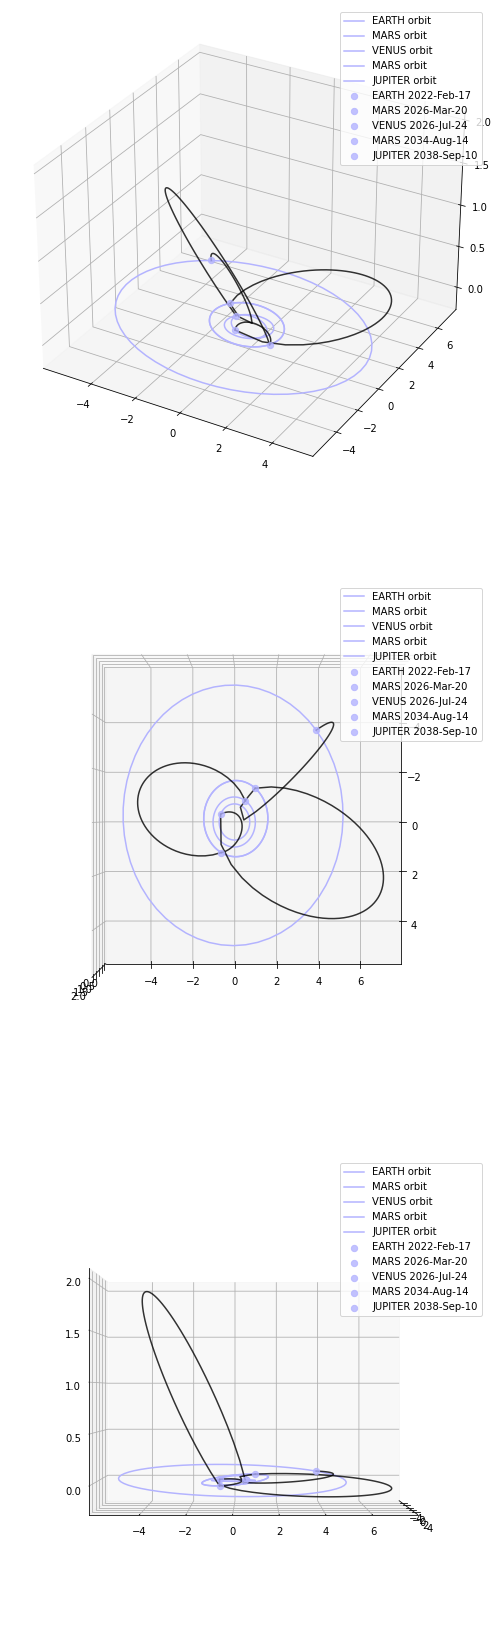

In [7]:
# results
direct_mga.pretty(x_direct)
print('Total delta_v:',delta_v[0],'[m/s]\n')
fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(3, 1, 1, projection='3d')
ax2 = fig.add_subplot(3, 1, 2, projection='3d')
ax3 = fig.add_subplot(3, 1, 3, projection='3d')
ax1 = direct_mga.plot(x_direct, axes = ax1)
ax2 = direct_mga.plot(x_direct,  axes = ax2)
ax2.view_init(elev=90, azim=0)
ax3 = direct_mga.plot(x_direct, axes = ax3)
ax3.view_init(elev=0, azim=0)

**DEMONSTRATION OF ALPHA TRANSCRIPTION of MGA**

Alpha transcription creates a formulation where only the end time-of-flight is both lower- and upper-bounded, and the intermediate legs are a fraction of that final time-of-flight. It allows a user to avoid specifying information for each leg (let's say you don't know), and it's an easier format for an algorithm to traverse.

At this point, you'd use the alpha transcription with an optimizer to figure out the best distribution of the tofs. There's little point in running it straight. You'd use this formulation for sweeping through and making porkchop plots (multiple combinations of sum of tofs gives the same overall tof, but which is the lowest dV for overall tof?)

The MGA object created has a method that allows you to transform the alpha decision vector back into direct times, and then you can use it with the direct transcription object as a function.

In [8]:
# Alpha Transcription MGA, no variation in departure time, single objective
T0_u = 0  # upper bound on departure time
tof_bounds = [50, 6000]  # window for entire trajectory
encoding = 'alpha'

# Multi-Gravity Assist, User-Defined Problem for Optimization
alpha_mga = pk.trajopt.mga(
    seq=planet_sequence,
    t0=[T0,pk.epoch(T0.mjd2000+T0_u)],
    tof=tof_bounds,
    vinf=Vinf_dep,
    multi_objective=multi_objective,
    tof_encoding=encoding,
    orbit_insertion=orbit_insertion,
    e_target=e_target,
    rp_target=rp_target
)

**SETTING UP THE OPTIMIZATION ALGORITHM**

We need to make a pygmo problem, algorithm, and population. As the MGA object does not have a gradient, whatever algorithm to be used should not rely on gradient information. Check out pygmo documentation for fun.

In [9]:
# declare problem (and tolerances)
prob = pg.problem(alpha_mga)
# algorithm setup; each library of solvers uses different setups. this one will demonstrate NLopt setup.
nl_setup = pg.nlopt('bobyqa')
nl_setup.xtol_rel = 1e-8
nl_setup.maxeval = 1500
algo = pg.algorithm(nl_setup)
# set up individuals to evolve
pop = pg.population(prob, 200)

# perform the optimization until either stopping criteria is first reached
pop = algo.evolve(pop)

# retrieve data
alpha_delta_v = pop.get_f()[pop.best_idx()]
__, *best_tofs = alpha_mga.alpha2direct(pop.get_x()[pop.best_idx()])

Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['EARTH', 'MARS', 'VENUS', 'MARS', 'JUPITER']
Departure:  EARTH
	Epoch:  8083.831053843207  [mjd2000]
	Spacecraft velocity:  (-22063.87956222283, -29391.20092390074, 138.26592773048085) [m/s]
	Hyperbolic velocity:  7243.149168691945 [m/s]
	Initial DV:  5243.149168691945 [m/s]
Fly-by:  MARS
	Epoch:  9003.776206163568  [mjd2000]
	DV:  29778.719844268722 [m/s]
Fly-by:  VENUS
	Epoch:  9938.021915418816  [mjd2000]
	DV:  0.0016914558667664816 [m/s]
Fly-by:  MARS
	Epoch:  12707.82378662585  [mjd2000]
	DV:  2123.24612057961 [m/s]
Arrival:  JUPITER
	Epoch:  13608.48747944454  [mjd2000]
	Spacecraft velocity:  (-6731.587688822392, 2009.4499603158763, 181.857310017533) [m/s]
	Arrival DV:  2369.603169605256 [m/s]
Time of flights:  [ 919.94515232  934.24570926 2769.80187121  900.66369282] [days]
Total delta_v: 39514.7199946014 [m/s]



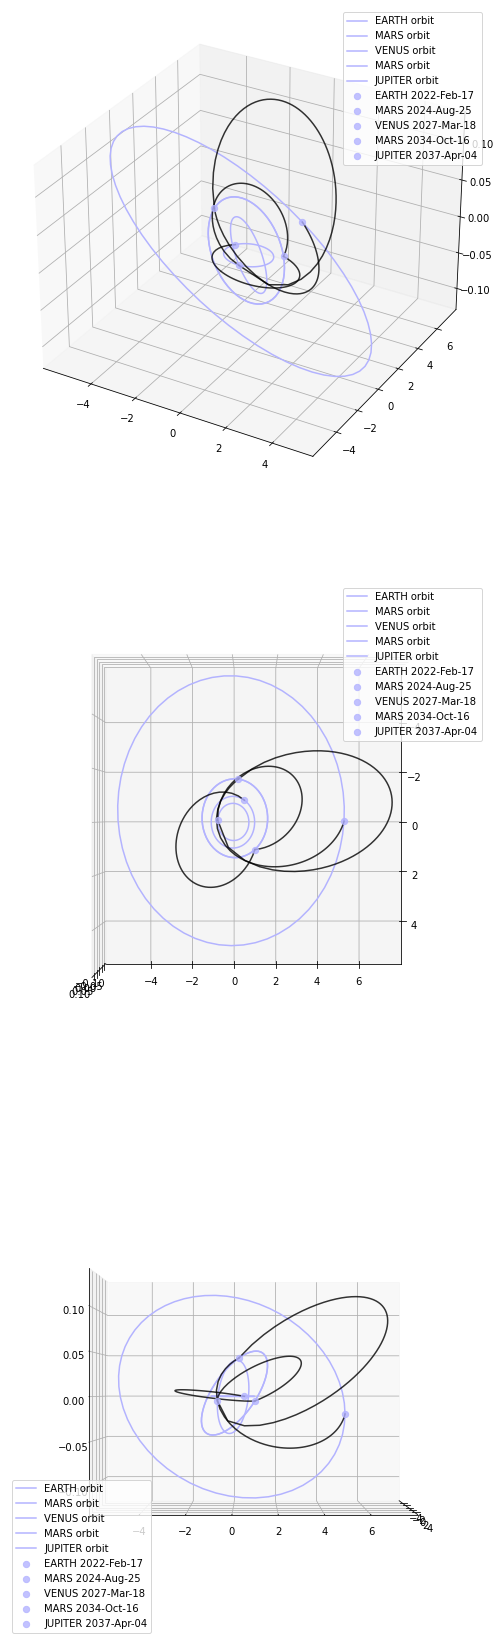

In [10]:
# results
alpha_mga.pretty(pop.get_x()[pop.best_idx()])
print('Total delta_v:',alpha_delta_v[0],'[m/s]\n')
fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(3, 1, 1, projection='3d')
ax2 = fig.add_subplot(3, 1, 2, projection='3d')
ax3 = fig.add_subplot(3, 1, 3, projection='3d')
ax1 = alpha_mga.plot(pop.get_x()[pop.best_idx()], axes = ax1)
ax2 = alpha_mga.plot(pop.get_x()[pop.best_idx()],  axes = ax2)
ax2.view_init(elev=90, azim=0)
ax3 = alpha_mga.plot(pop.get_x()[pop.best_idx()], axes = ax3)
ax3.view_init(elev=0, azim=0)

The input format for *eta* transcription will allow freedom for the total time-of-flight to an upper bound. This time, we'll also free up departure time for a window, too.

In [11]:
# ETA Transcription MGA, vary departure time, single objective
T0_u = 1000  # upper bound on departure time
tof_bounds = 6000  # window for entire trajectory
encoding = 'eta'

# Multi-Gravity Assist, User-Defined Problem for Optimization
eta_mga = pk.trajopt.mga(
    seq=planet_sequence,
    t0=[T0,pk.epoch(T0.mjd2000+T0_u)],
    tof=tof_bounds,
    vinf=Vinf_dep,
    multi_objective=multi_objective,
    tof_encoding=encoding,
    orbit_insertion=orbit_insertion,
    e_target=e_target,
    rp_target=rp_target
)

In [12]:
# declare problem (and tolerances)
prob = pg.problem(eta_mga)
# set up individuals to evolve
pop = pg.population(prob, 200)

# perform the optimization until either stopping criteria is first reached
pop = algo.evolve(pop)

# retrieve data
eta_delta_v = pop.get_f()[pop.best_idx()]
__, *best_tofs = eta_mga.eta2direct(pop.get_x()[pop.best_idx()])

Eta Transcription, best dV, newuoa
Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['EARTH', 'MARS', 'VENUS', 'MARS', 'JUPITER']
Departure:  EARTH
	Epoch:  8088.268175051371  [mjd2000]
	Spacecraft velocity:  (-478.0736906226193, -31630.730795720643, -694.8744226442363) [m/s]
	Hyperbolic velocity:  14288.911772267327 [m/s]
	Initial DV:  12288.911772267327 [m/s]
Fly-by:  MARS
	Epoch:  8408.298449154354  [mjd2000]
	DV:  28098.3830196056 [m/s]
Fly-by:  VENUS
	Epoch:  11159.410594686557  [mjd2000]
	DV:  0.00015999718016246334 [m/s]
Fly-by:  MARS
	Epoch:  13422.825752875046  [mjd2000]
	DV:  83.51889638279317 [m/s]
Arrival:  JUPITER
	Epoch:  14070.227022225656  [mjd2000]
	Spacecraft velocity:  (-7595.19100012477, 2681.8047505194295, 160.93419621870396) [m/s]
	Arrival DV:  3943.8862956545854 [m/s]
Time of flights:  [320.0302741029836, 2751.1121455322027, 2263.4151581884894, 647.4012693506098] [days]
Total delta_v: 44414.70014390749 [m/s]



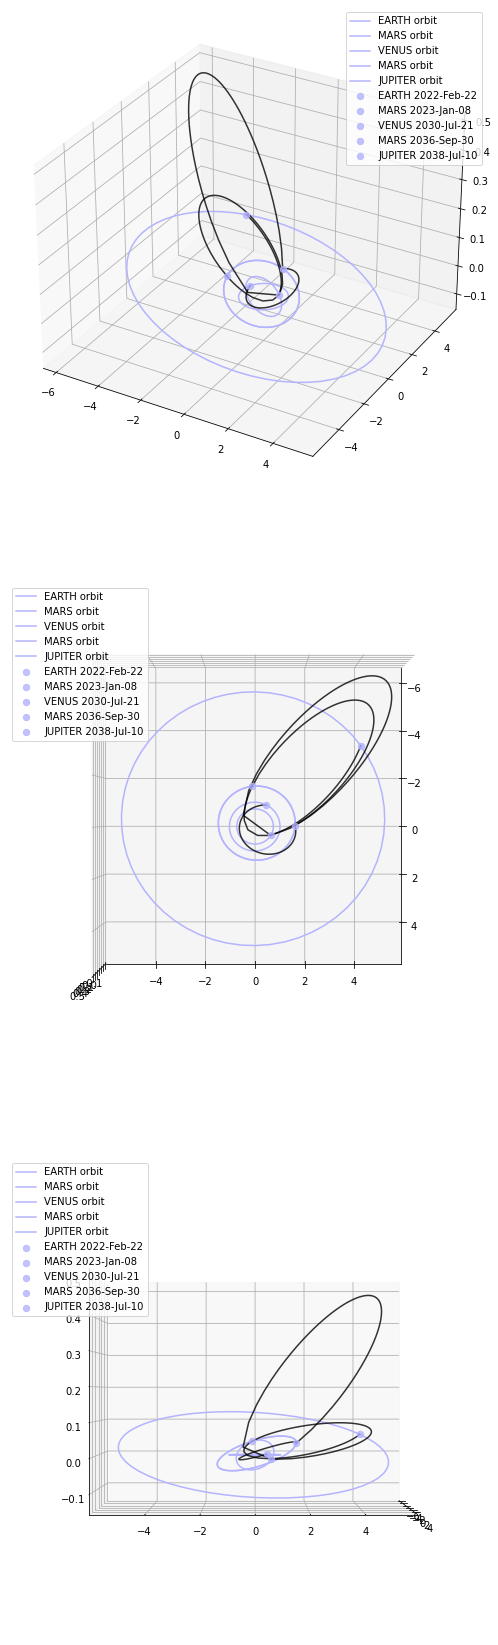

In [13]:
# results
print("Eta Transcription, best dV, newuoa")
eta_mga.pretty(pop.get_x()[pop.best_idx()])
print("Total delta_v:", eta_delta_v[0], "[m/s]\n")
fig2 = plt.figure(figsize=(30, 30))
ax1 = fig2.add_subplot(3, 1, 1, projection="3d")
ax2 = fig2.add_subplot(3, 1, 2, projection="3d")
ax3 = fig2.add_subplot(3, 1, 3, projection="3d")
ax1 = eta_mga.plot(pop.get_x()[pop.best_idx()], axes=ax1)
ax2 = eta_mga.plot(pop.get_x()[pop.best_idx()], axes=ax2)
ax2.view_init(elev=90, azim=0)
ax3 = eta_mga.plot(pop.get_x()[pop.best_idx()], axes=ax3)
ax3.view_init(elev=0, azim=0)

**CREATING A PORKCHOP PLOT**

Porkchop plots are $C_3$ contour plots of various depature times versus time-of-flights. Here, we'll use the *alpha* transcription to generate the 'best' $\Delta v$ for a given total time-of-flight by wrapping the optimization as a function call, and then performing sweeps.

In [14]:
# create function for t0, tof in; dv, tof_i out.
def mga_dV(t0: type(pk.epoch(0)), tof: float):
    mga_udp = pk.trajopt.mga(
        seq=planet_sequence,
        t0=[t0, t0],
        tof=[tof, tof],
        vinf=Vinf_dep,
        multi_objective=False,
        tof_encoding="alpha",
        orbit_insertion=orbit_insertion,
        e_target=e_target,
        rp_target=rp_target,
    )

    # declare problem (and tolerances)
    prob = pg.problem(mga_udp)
    # algorithm setup; each library of solvers uses different setups. this one will demonstrate NLopt setup.
    nl_setup = pg.nlopt("bobyqa")
    nl_setup.xtol_rel = 1e-6
    # nl_setup.maxeval = 1500
    algo = pg.algorithm(nl_setup)
    # set up individuals to evolve
    pop = pg.population(prob, 200)

    # perform the optimization until either stopping criteria is first reached
    pop = algo.evolve(pop)

    # retrieve data
    alpha_delta_v = pop.get_f()[pop.best_idx()]
    __, *best_tofs = alpha_mga.alpha2direct(pop.get_x()[pop.best_idx()])
    return alpha_delta_v, best_tofs

In [15]:
# create sweeps and storage
n = 50
dt_departure = np.empty([n,])
t_step = 30.0
dt_arrival = np.linspace(100, 3000, n, True)
dVs = np.empty([n, n])
dT1 = np.empty([n, n])
dT2 = np.empty([n, n])

In [16]:
for i in range(0, n):
    t0 = pk.epoch(T0.mjd2000 + i * t_step)
    dt_departure[i] = t0.mjd2000
    for j, tf in enumerate(dt_arrival):
        dv, ti = mga_dV(t0, tf)
        dVs[i][j] = dv
        dT1[i][j] = ti[0]
        dT2[i][j] = ti[1]
        dVs[i][j] = dv
        dT1[i][j] = ti[0]
        dT2[i][j] = ti[1]

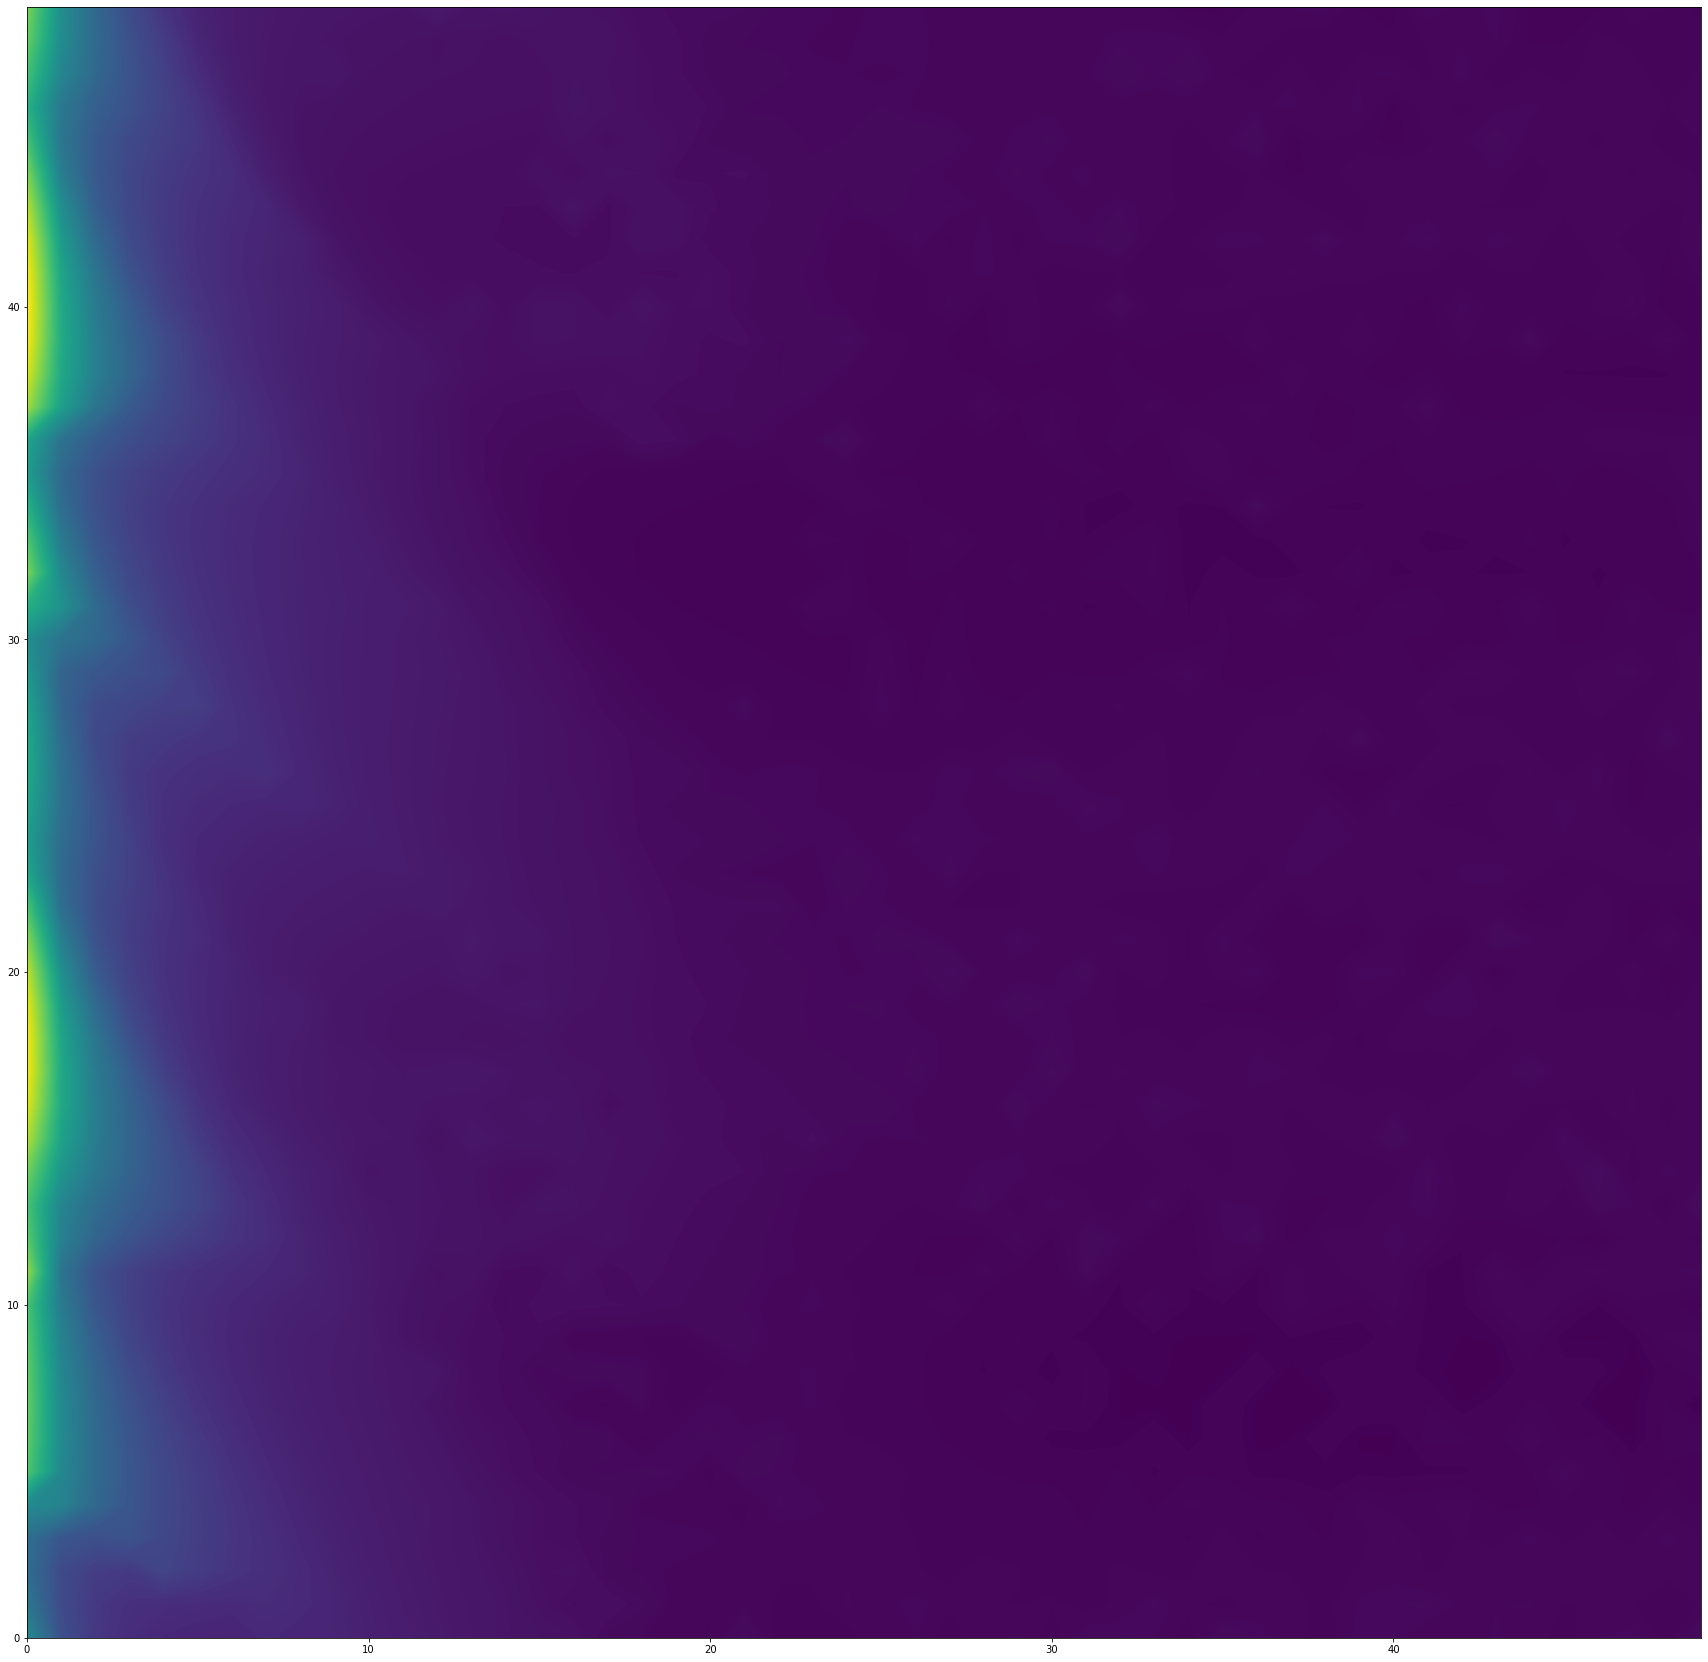

In [18]:
# plotting is up to the user
fig4 = plt.figure(figsize=(30, 30))
plt.contourf(dVs, 500)